In [7]:
from skimage.feature import peak_local_max
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from collections import Counter
import os

1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.


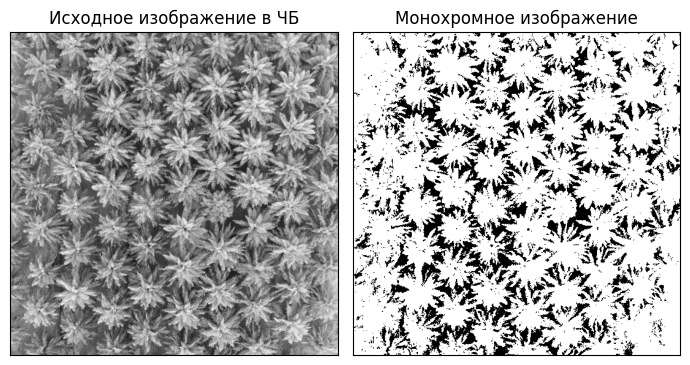

In [8]:
print("1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.")

img = cv2.imread('../data/palm_1.JPG', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise Exception("Изображение не найдено")
else:
    _, monoImg = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    with open('../data/monoImg.txt', 'w') as file:
        for r in monoImg:
            line = ' '.join(str(pixel) for pixel in r)
            file.write(line + '\n')

    plt.figure(figsize=(7, 4))

    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title('Исходное изображение в ЧБ')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,2,2)
    plt.imshow(monoImg, cmap='gray')
    plt.title('Монохромное изображение')
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()
    plt.show()
    print("\n\n")

2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.


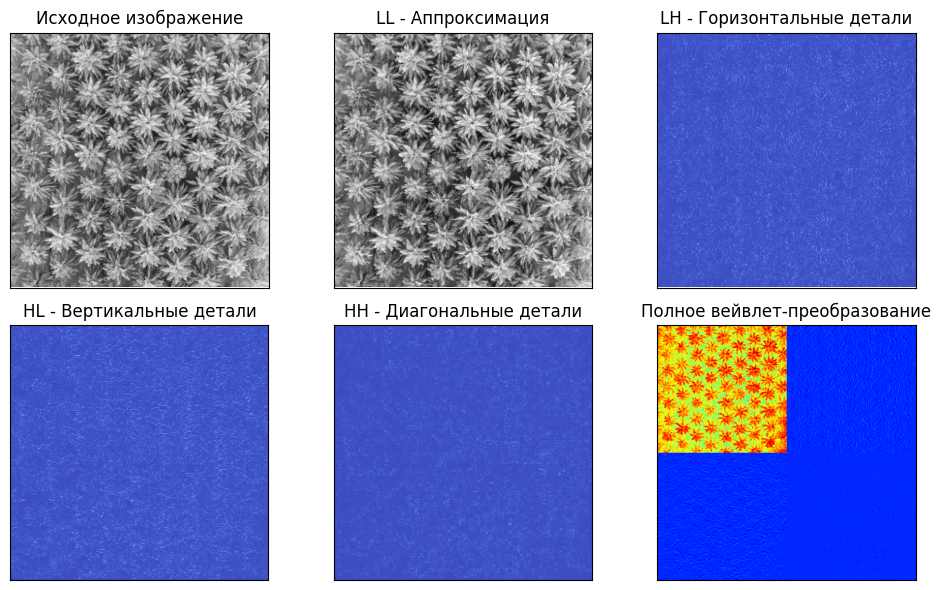

In [9]:
print("2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.")

def wavelet_haar(data):
    data = data.astype(np.float32)
    rows, cols = data.shape

    horizontal = np.zeros_like(data)

    for row_idx in range(rows):
        col_idx = 0
        while col_idx < cols - 1:
            pixel1 = data[row_idx, col_idx]
            pixel2 = data[row_idx, col_idx + 1]

            average = (pixel1 + pixel2) / 2.0
            difference = (pixel1 - pixel2) / 2.0

            horizontal[row_idx, col_idx // 2] = average
            horizontal[row_idx, col_idx // 2 + cols // 2] = difference

            col_idx += 2

        if cols % 2 != 0:
            horizontal[row_idx, cols // 2] = data[row_idx, -1]

    vertical = np.zeros_like(horizontal)

    for col_idx in range(cols):
        row_idx = 0
        while row_idx < rows - 1:
            pixel1 = horizontal[row_idx, col_idx]
            pixel2 = horizontal[row_idx + 1, col_idx]

            average = (pixel1 + pixel2) / 2.0
            difference = (pixel1 - pixel2) / 2.0

            vertical[row_idx // 2, col_idx] = average
            vertical[row_idx // 2 + rows // 2, col_idx] = difference

            row_idx += 2

        if rows % 2 != 0:
            vertical[rows // 2, col_idx] = horizontal[-1, col_idx]

    half_rows = rows // 2
    half_cols = cols // 2

    ll_component = vertical[:half_rows, :half_cols]        # Аппроксимация
    lh_component = vertical[:half_rows, half_cols:]        # Горизонтальные детали
    hl_component = vertical[half_rows:, :half_cols]        # Вертикальные детали
    hh_component = vertical[half_rows:, half_cols:]        # Диагональные детали

    return ll_component, lh_component, hl_component, hh_component, vertical

LL, LH, HL, HH, full_transform = wavelet_haar(img)

plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 2)
plt.imshow(LL, cmap='gray')
plt.title('LL - Аппроксимация', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 3)
plt.imshow(np.abs(LH), cmap='coolwarm')
plt.title('LH - Горизонтальные детали', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 4)
plt.imshow(np.abs(HL), cmap='coolwarm')
plt.title('HL - Вертикальные детали', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 5)
plt.imshow(np.abs(HH), cmap='coolwarm')
plt.title('HH - Диагональные детали', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 6)
plt.imshow(full_transform, cmap='jet')
plt.title('Полное вейвлет-преобразование', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()
print("\n\n")

3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).


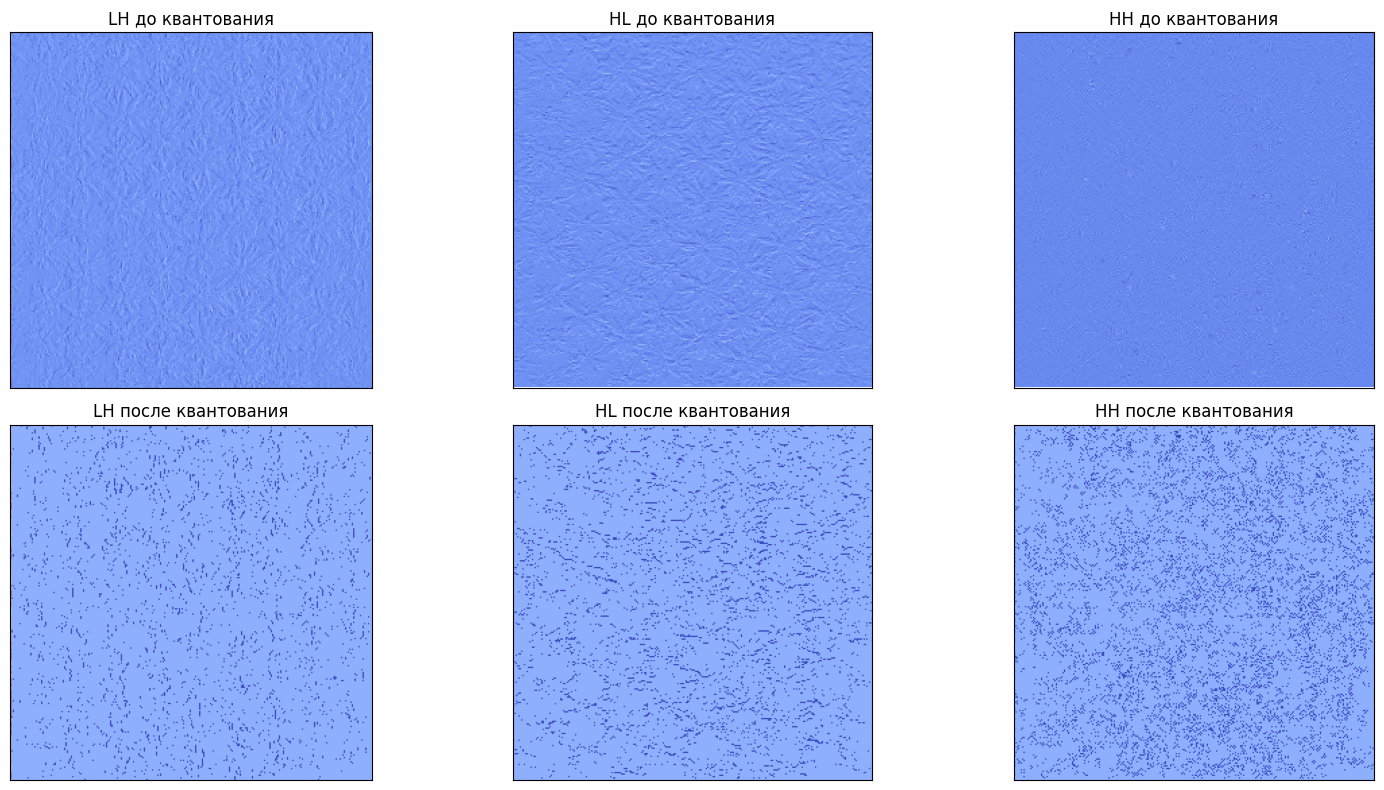

In [10]:
print("3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).")

def quantize_data(component, levels):
    min_value = np.min(component)
    max_value = np.max(component)
    step_size = (max_value - min_value) / levels
    quant_result = np.round((component - min_value) / step_size).astype(int)
    return quant_result, min_value, step_size

levels = 4

lh_quantize, lh_min, lh_step = quantize_data(LH, levels)
hl_quantize, hl_min, hl_step = quantize_data(HL, levels)
hh_quantize, hh_min, hh_step = quantize_data(HH, levels)

def dequantize_data(quant_comp, min_value, step_size):
    return min_value + quant_comp * step_size

lh_restored = dequantize_data(lh_quantize, lh_min, lh_step)
hl_restored = dequantize_data(hl_quantize, hl_min, hl_step)
hh_restored = dequantize_data(hh_quantize, hh_min, hh_step)

plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(LH, cmap='coolwarm')
plt.title('LH до квантования')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 2)
plt.imshow(HL, cmap='coolwarm')
plt.title('HL до квантования')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 3)
plt.imshow(HH, cmap='coolwarm')
plt.title('HH до квантования')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 4)
plt.imshow(lh_restored, cmap='coolwarm')
plt.title('LH после квантования')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 5)
plt.imshow(hl_restored, cmap='coolwarm')
plt.title('HL после квантования')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 3, 6)
plt.imshow(hh_restored, cmap='coolwarm')
plt.title('HH после квантования')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

In [11]:
print("4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).")

def encode_rle(comp_data):
    rle_result = []
    for val, cnt in Counter(comp_data.flatten()).items():
        rle_result.append((val, cnt))
    return rle_result

# Кодируем высокочастотные компоненты
lh_encoded = encode_rle(lh_quantize)
hl_encoded = encode_rle(hl_quantize)
hh_encoded = encode_rle(hh_quantize)


with open('../data/haar.txt', 'w') as file:
    np.savetxt(file, LL, fmt='%d')
    file.write('\n')

    high_freq = [('LH', lh_encoded), ('HL', hl_encoded), ('HH', hh_encoded)]

    for name, encoded_data in high_freq:
        for val, cnt in encoded_data:
            file.write(f"{val} {cnt}\n")
        file.write('\n')

print("Данные сохранены в haar_components.txt")

4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).
Данные сохранены в haar_components.txt


In [12]:
print("5. Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и изображение, полученным после преобразования Хаара и сжатием длин серий.")
with open('../data/monoImg.txt', 'r') as f:
    o_size = len(f.read().encode('utf-8'))

with open('../data/haar.txt', 'r') as f:
    h_size = len(f.read().encode('utf-8'))

print(f"Монохромное изображение в текстовом файле: : {o_size} байт")
print(f"Изображение, обработанного преобразованием Хаара: : {h_size} байт")
print(f"Сжали в {o_size/h_size:.1f} раз")

5. Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и изображение, полученным после преобразования Хаара и сжатием длин серий.
Монохромное изображение в текстовом файле: : 997044 байт
Изображение, обработанного преобразованием Хаара: : 278025 байт
Сжали в 3.6 раз
